## Problem Statement
You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

Credit card / Prepaid card

Bank account services

Theft/Dispute reporting

Mortgages/loans

Others

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Data Reading/Data Understanding
### Important Parameters for NLP
### For text analysis, classification, and sentiment analysis, the following parameters are useful:

#### 1. Complaint Text (complaint_what_happened)
#####  This is the key feature for text classification, sentiment analysis, and named entity recognition (NER).

#### 2. Issue & Sub-Issue
##### Useful for topic modeling and categorization.

#### 3. Product & Sub-Product
##### Helps in identifying the industry sector of complaints.

#### 4. Company Response
##### Can be used for sentiment analysis and predicting resolutions.

#### 5. Consumer Sentiment (Disputed & Consent Provided)
##### Indicators of how satisfied or dissatisfied the consumer is.

#### 6. Time-Based Trends
##### Can be used for time series analysis to identify seasonal complaint trends.

#### 7. Tags (e.g., Servicemember, Older American)
##### Useful for demographic-based analysis.

In [94]:
# Importing Libraries

import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# from google.colab import drive
# drive.mount('/content/drive')

## Loading the data

In [56]:

f = 'complaints-2021-05-14_08_16.json'

with open(f, 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

In [57]:
# Checking data
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [58]:
# Checking shape of the df
df.shape

(78313, 22)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [60]:
# Removing the '_' from the column names
df.columns = df.columns.str.replace('_', '')

# Replacing the 'source.' from the column names
df.columns = df.columns.str.replace('source.', '')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    78313 non-null  object 
 1   type                     78313 non-null  object 
 2   id                       78313 non-null  object 
 3   score                    78313 non-null  float64
 4   tags                     10900 non-null  object 
 5   zipcode                  71556 non-null  object 
 6   complaintid              78313 non-null  object 
 7   issue                    78313 non-null  object 
 8   datereceived             78313 non-null  object 
 9   state                    76322 non-null  object 
 10  consumerdisputed         78313 non-null  object 
 11  product                  78313 non-null  object 
 12  companyresponse          78313 non-null  object 
 13  company                  78313 non-null  object 
 14  submittedvia          

In [61]:
# Found some blanks in the column 'complaintwhathappened', need to check them and replace them with 'nan'.
print('Total Rows with blanks - ', len(df[df['complaintwhathappened'] == '']))
print('% of total rows with blanks - ', round(len(df[df['complaintwhathappened'] == '']) / len(df) * 100, 2), '%')

# Replace blanks in complaintwhathappened column with nan.
df['complaintwhathappened'] = df['complaintwhathappened'].replace('', np.nan)

Total Rows with blanks -  57241
% of total rows with blanks -  73.09 %


In [62]:
# After the blanks were replaced with nan, checking if the replace happened fine.
print('Total Rows with blanks - ', len(df[df['complaintwhathappened'] == '']))
print('% of total rows with blanks - ', round(len(df[df['complaintwhathappened'] == '']) / len(df) * 100, 2), '%')

Total Rows with blanks -  0
% of total rows with blanks -  0.0 %


In [63]:
# Those nan values will be counted as nulls now
df['complaintwhathappened'].isnull().sum()

57241

In [64]:
# Remove all rows where complaintwhathappened column has null values
df = df.dropna(subset = 'complaintwhathappened')

In [65]:
df.shape

(21072, 22)

## Prepare the text for topic modelling

#### Once you have removed all the blank complaints, you need to:

##### 1. Make the text lowercase
##### 2. Remove text in square brackets
##### 3. Remove punctuation
##### 4. Remove words containing numbers

#### Once you have done these cleaning operations you need to perform the following:

##### 1. Lemmatize the texts
##### 2. Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].



In [66]:
def clean_text(text):
    # Make the text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove words containing numbers
    text = ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

    return text

stopwords = nlp.Defaults.stop_words
def lemmatize_text(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [67]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()

In [68]:
# Clean text columns
!pip install tqdm
# Clean text columns
from tqdm import tqdm
tqdm.pandas() # Initialize tqdm for pandas

df_clean['complaintwhathappened'] = df['complaintwhathappened'].progress_apply(lambda x: clean_text(x))

100%|██████████| 21072/21072 [00:09<00:00, 2311.61it/s]


In [69]:
# lemmitize the text columns
df_clean['complaintwhathappened_lemmatized'] = lemmatize_text(df_clean['complaintwhathappened'])

21072it [13:00, 26.98it/s]


In [70]:
# adding category and sub_category columns to the dataframe for better topic identification
df_clean['category'] = df['product']
df_clean['sub_category'] = df['subproduct']
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   complaintwhathappened             21072 non-null  object
 1   complaintwhathappened_lemmatized  21072 non-null  object
 2   category                          21072 non-null  object
 3   sub_category                      18963 non-null  object
dtypes: object(4)
memory usage: 823.1+ KB


In [71]:
#Write your function to extract the POS tags only for NN
def extract_pos_tags(texts):
    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_sentences.append(' '.join(sent))
    return pos_sentences

df_clean["complaint_POS_removed"] = extract_pos_tags(df_clean['complaintwhathappened_lemmatized'])
df_clean.info()

21072it [05:05, 68.88it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   complaintwhathappened             21072 non-null  object
 1   complaintwhathappened_lemmatized  21072 non-null  object
 2   category                          21072 non-null  object
 3   sub_category                      18963 non-null  object
 4   complaint_POS_removed             21072 non-null  object
dtypes: object(5)
memory usage: 987.8+ KB


In [72]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaintwhathappened,complaintwhathappened_lemmatized,category,sub_category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,"Credit reporting, credit repair services, or o...",Credit reporting,book offer ticket reward card information minu...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account,Checking account,son deposit chase account fund account pay mon...


## Exploratory data analysis to get familiar with the data.

##### Write the code in this task to perform the following:

##### Visualise the data according to the 'Complaint' character length
##### Using a word cloud find the top 40 words by frequency among all the articles after processing the text
##### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [73]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaintwhathappened'].str.len()
df_clean['complaintwhathappened_lemmatized_length'] = df_clean['complaintwhathappened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaintwhathappened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

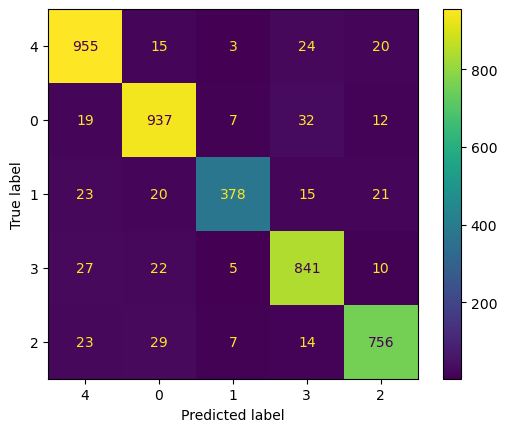

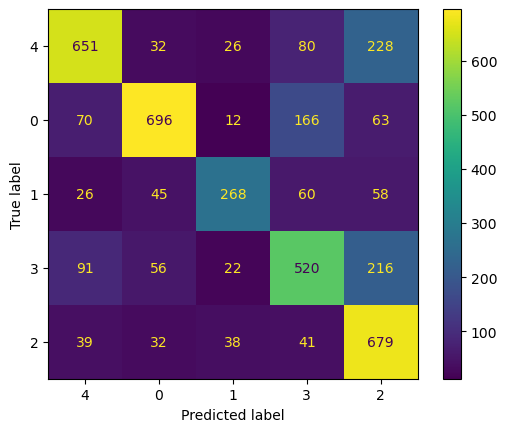

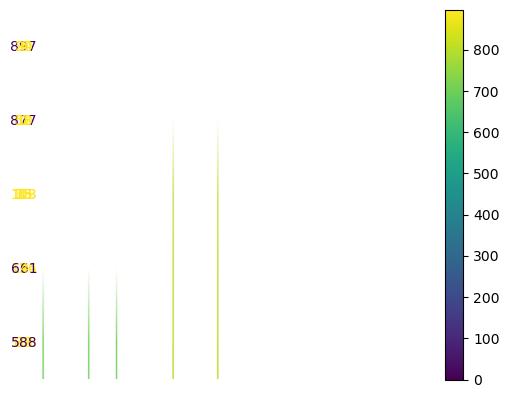

In [74]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [75]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [76]:
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [77]:
#Print the top 10 words in the unigram frequency and plot the same using a bar graph
unigram = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

chase 56710
account 41041
credit 33390
card 29758
payment 20893
charge 16099
time 15285
bank 12332
call 11916
money 11539


credit card 12658
credit report 3826
chase credit 3062
customer service 2946
call chase 2893
account chase 2605
chase bank 2598
chase account 2282
contact chase 1973
debit card 1898


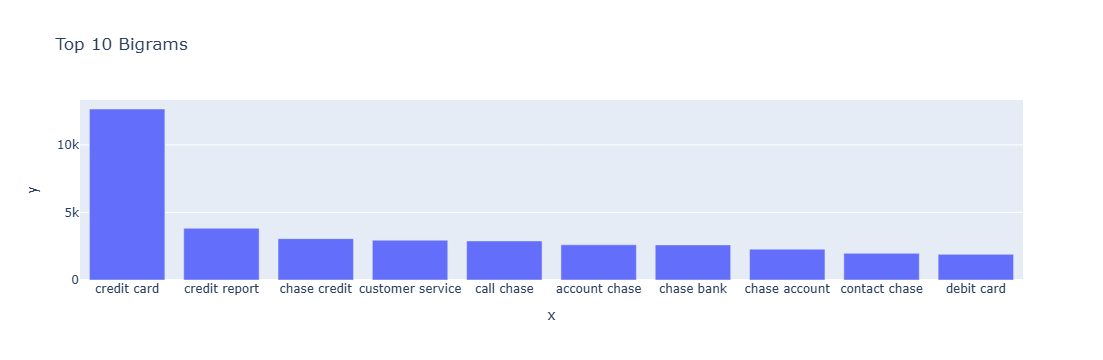

In [78]:
#Print the top 10 words in the bigram frequency and plot the same using a bar graph
bigram = get_top_n_words(df_clean['Complaint_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 Bigrams')

chase credit card 2166
credit card account 1030
credit card company 978
credit card chase 813
chase customer service 602
inquiry credit report 480
charge credit card 475
credit card credit 437
credit reporting agency 378
call customer service 361


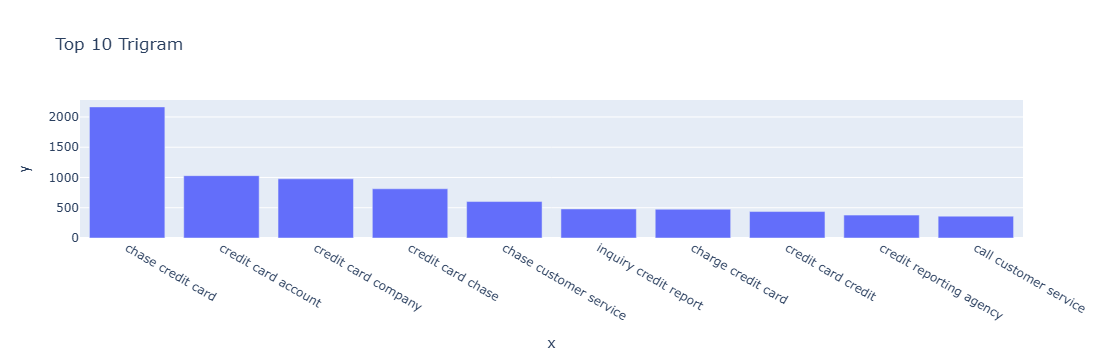

In [79]:
#Print the top 10 words in the trigram frequency and plot the same using a bar graph
trigram = get_top_n_words(df_clean['Complaint_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 Trigram')

In [80]:
# The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our
# analysis
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [81]:
#All masked texts has been removed
df_clean.head()

,complaintwhathappened,complaintwhathappened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaintwhathappened_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help chase debt verification statement...,469,289,132,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent informatio...,334,205,94,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,card report application identity consent servi...,209,132,88,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,"Credit reporting, credit repair services, or o...",Credit reporting,book offer ticket reward card information minu...,1424,744,419,book offer ticket reward card information minu...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account,Checking account,son deposit chase account fund account pay mon...,452,276,152,son deposit chase account fund account pay mon...


## Feature Extraction
##### Convert the raw texts to a matrix of TF-IDF features

##### max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms
##### that appear in more than 95% of the complaints"

##### min_df is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [82]:
# Write your code here to initialise the TfidfVectorizer
tf_idf_vec = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [83]:
# Create a document term matrix using fit_transform
# The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score: The tuples that are not there have a tf-idf score
# of 0

In [84]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tf_idf_vec.fit_transform(df_clean['Complaint_clean'])


In [85]:
# Topic Modelling using NMF
# Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

# In this task you have to perform the following:

# Find the best number of clusters
# Apply the best number to create word clusters
# Inspect & validate the correction of each cluster wrt the complaints
# Correct the labels if needed
# Map the clusters to topics/cluster names

In [86]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
#### You need to do take the trial & error approach to find the best num of topics for your NMF model.

#### The only parameter that is required is the number of components i.e. the number of topics we want.
#### This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [87]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state = 40
nmf_model = NMF(n_components = num_topics, random_state = 40)

In [88]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6454

In [89]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['customer', 'business', 'claim', 'transaction', 'number', 'transfer', 'branch', 'day', 'fund', 'bank', 'deposit', 'chase', 'money', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['reporting', 'year', 'letter', 'application', 'limit', 'debt', 'information', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['year', 'error', 'mortgage', 'date', 'credit', 'chase', 'auto', 'time', 'day', 'fee', 'statement', 'pay', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['email', 'statement', 'time', 'fraud', 'balance', 'service', 'claim', 'merchant', 'purchase', 'transaction', 'chase', 'dispute', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['information', 'sale', 'foreclosure', 'time', 'request', 'rate', 'document', 'letter', 'year', 'property', 'home', 'modification', 'chase', 'mortga

In [90]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis = 1)

array([4, 0, 1, ..., 3, 2, 2], dtype=int64)

In [91]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis = 1)

In [92]:
df_clean.head()

,complaintwhathappened,complaintwhathappened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaintwhathappened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help chase debt verification statement...,469,289,132,morning help chase debt verification statement...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent informatio...,334,205,94,agent anniversary date change agent informatio...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,card report application identity consent servi...,209,132,88,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,"Credit reporting, credit repair services, or o...",Credit reporting,book offer ticket reward card information minu...,1424,744,419,book offer ticket reward card information minu...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account,Checking account,son deposit chase account fund account pay mon...,452,276,152,son deposit chase account fund account pay mon...,0


In [93]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values(by ='Topic')

,complaintwhathappened,complaintwhathappened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaintwhathappened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,Checking or savings account,Checking account,account bonus call xxxxxxxx term account depos...,401,188,100,account bonus call term account deposit bonus...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent informatio...,334,205,94,agent anniversary date change agent informatio...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account,Checking account,son deposit chase account fund account pay mon...,452,276,152,son deposit chase account fund account pay mon...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,Checking or savings account,Checking account,account debit card branch customer service rep...,2221,1239,652,account debit card branch customer service rep...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,Vehicle loan or lease,Loan,account chase auto xxxx,50,33,23,account chase auto,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,card report application identity consent servi...,209,132,88,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,"Credit reporting, credit repair services, or o...",Credit reporting,book offer ticket reward card information minu...,1424,744,419,book offer ticket reward card information minu...,1
15,can you please remove inquiry,remove inquiry,"Credit reporting, credit repair services, or o...",Credit reporting,inquiry,29,14,7,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,Credit card or prepaid card,General-purpose credit card or charge card,chase credit card datum credit report company ...,127,83,56,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,reach xxxx time attempt fraudulent inquiry rem...,"Credit reporting, credit repair services, or o...",Credit reporting,time attempt inquiry remove contact creditor i...,734,369,197,time attempt inquiry remove contact creditor i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
##### Bank Account services
##### Credit card or prepaid card
##### Theft/Dispute Reporting
##### Mortgage/Loan
##### Others

In [95]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [96]:
df_clean.head()

,complaintwhathappened,complaintwhathappened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaintwhathappened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help chase debt verification statement...,469,289,132,morning help chase debt verification statement...,4,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent informatio...,334,205,94,agent anniversary date change agent informatio...,0,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,card report application identity consent servi...,209,132,88,card report application identity consent servi...,1,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,"Credit reporting, credit repair services, or o...",Credit reporting,book offer ticket reward card information minu...,1424,744,419,book offer ticket reward card information minu...,1,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account,Checking account,son deposit chase account fund account pay mon...,452,276,152,son deposit chase account fund account pay mon...,0,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.
#### You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

#### Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [97]:
#Keep the columns "complaintwhathappened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaintwhathappened','Topic']]
training_data

,complaintwhathappened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i c...,1
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had cha...,2


## Apply the supervised models on the training data created. In this process, you have to do the following:
##### Create the vector counts using Count Vectoriser
##### Transform the word vector to tf-idf
##### Create the train & test data using the train_test_split on the tf-idf & topics

In [98]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # Import TfidfTransformer

count_vect = CountVectorizer()
# Write your code to get the Vector count
X_train_counts = count_vect.fit_transform(training_data['complaintwhathappened'])
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tf.toarray())
print(X_train_tf.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(21072, 33599)


In [99]:
# Checking for class imbalance
px.bar(x = training_data['Topic'].value_counts().index,
       y = training_data['Topic'].value_counts().values,
       title='Class Imbalance')

#### As class imbalace is present in the data, but is not very severe, we will not be using any sampling techniques to balance the data.
#### We will be using F1 score as the evaluation metric for the models and stratified k-fold cross validation to evaluate the models.

#### You have to try atleast 3 models on the train & test data from these options:

##### Logistic regression
##### Decision Tree
##### Random Forest
##### Naive Bayes (optional)
##### Using the required evaluation metrics judge the tried models and select the ones performing the best

In [100]:
# Importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
# from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [101]:
# Prepare the training and test data
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size = 0.2, random_state = 100)

In [102]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,type='Training'):
    print(type,'results')
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', round(accuracy, 2))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted').round(2))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted').round(2))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted').round(2))
    # print('ROC AUC Score: ', roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()

In [103]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

##### Logistic regression model

In [104]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(random_state=100, max_iter=1000)

# Fit the model to the training data
logistic_model.fit(train_X, train_y)

# Predict the test data
pred_y_logistic = logistic_model.predict(test_X)

# print('Accuracy: ', accuracy_score(test_y,pred_y).round(2))
eval_model(test_y, pred_y_logistic)

Training results
Accuracy: 0.92
Precision:  0.92
Recall:  0.92
F1 Score:  0.92
Classification Report:                precision    recall  f1-score   support

           0       0.91      0.94      0.93      1017
           1       0.92      0.93      0.92      1007
           2       0.94      0.83      0.88       457
           3       0.91      0.93      0.92       905
           4       0.92      0.91      0.92       829

    accuracy                           0.92      4215
   macro avg       0.92      0.91      0.91      4215
weighted avg       0.92      0.92      0.92      4215



##### Decision tree

In [105]:
# Initialize the Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier(random_state=100, max_depth=5)  # You can adjust max_depth as needed

# Fit the model to the training data
decision_tree_model.fit(train_X, train_y)

# Predict the test data
y_pred_decision_tree = decision_tree_model.predict(test_X)
eval_model(test_y, y_pred_decision_tree)

Training results
Accuracy: 0.67
Precision:  0.69
Recall:  0.67
F1 Score:  0.67
Classification Report:                precision    recall  f1-score   support

           0       0.74      0.64      0.69      1017
           1       0.81      0.69      0.75      1007
           2       0.73      0.59      0.65       457
           3       0.60      0.57      0.59       905
           4       0.55      0.82      0.66       829

    accuracy                           0.67      4215
   macro avg       0.69      0.66      0.67      4215
weighted avg       0.69      0.67      0.67      4215



##### Random forest

In [106]:
# Initialize the Random Forest Classifier
random_forest_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=100,  # Ensures reproducibility
    max_depth=10,      # Maximum depth of the trees (adjust as needed)
    n_jobs=-1          # Use all processors for parallel training
)

# Fit the model to the training data
random_forest_model.fit(train_X, train_y)

# Predict the test data
y_pred_random_forest = random_forest_model.predict(test_X)

eval_model(test_y, y_pred_random_forest)

Training results
Accuracy: 0.72
Precision:  0.76
Recall:  0.72
F1 Score:  0.68
Classification Report:                precision    recall  f1-score   support

           0       0.70      0.88      0.78      1017
           1       0.63      0.87      0.73      1007
           2       1.00      0.03      0.06       457
           3       0.78      0.73      0.75       905
           4       0.86      0.71      0.78       829

    accuracy                           0.72      4215
   macro avg       0.79      0.64      0.62      4215
weighted avg       0.76      0.72      0.68      4215



## Model Inference
#### Metric	     Logistic Regression	Random Forest	Decision Tree
##### Accuracy	        0.92	        0.72	        0.67
##### Precision	        0.92	        0.76	        0.69
##### Recall            0.92            0.72	        0.67  
##### F1 Score	        0.92	        0.68	        0.67
#####
#### Key Insights and Recommendations
##### Logistic Regression is the Best Model Overall
##### Highest accuracy, precision, recall, and F1-score.
##### Stable performance across all classes, making it the most reliable choice.
##### If interpretability is important, this model is easier to explain compared to Random Forest.
#####
#### Random Forest is Second Best but Has Issues
##### Works better for imbalanced datasets but needs improvements.
#####
#### Decision Tree is the Weakest Model
##### Lowest accuracy and inconsistent class-wise performance.
##### Higher variance, meaning it’s prone to overfitting.
##### May work better with pruning or boosting techniques.
#####
### Final Recommendation
##### ✅ Choose Logistic Regression for best overall performance.
##### ⚠️ If you want a more robust, ensemble-based model, optimize Random Forest (hyperparameter tuning, feature selection).
##### ❌ Avoid Decision Tree unless using boosting techniques like XGBoost or pruning.